In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
data = pd.read_csv('hour_online.csv', index_col = 'Time', parse_dates = True)
data.head()

C:\Users\ksyuk\AppData\Local\Temp\ipykernel_2040\3980820583.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('hour_online.csv', index_col = 'Time', parse_dates = True)


,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517
2017-01-01 03:00:00,44476
2017-01-01 04:00:00,46234


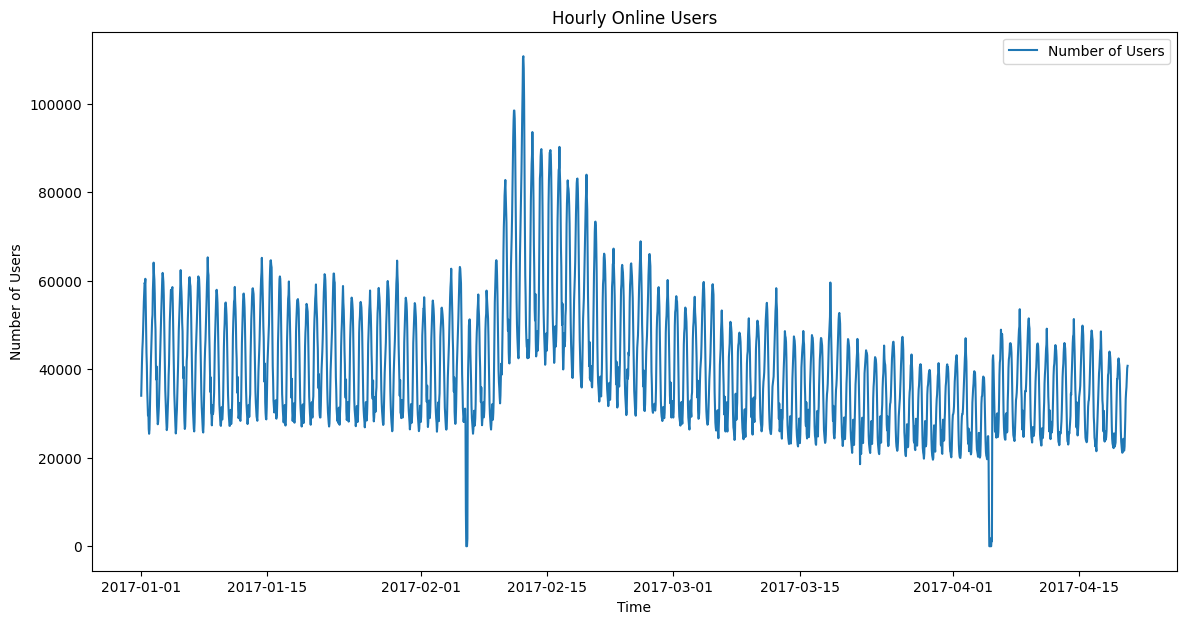

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Users'], label='Number of Users')
plt.xlabel('Time')
plt.ylabel('Number of Users')
plt.title('Hourly Online Users')
plt.legend()
plt.show()

## Во время дифференцирования тренд и сезонность уменьшаются, а логарифмирование подходит для данных, резко возрастающих или колеблющихся вокруг положительных значений.

## Метод Хольта

# Этапы:
<li> Импорт данных с правильным форматом времени 
<li> Просмотр графика данных, определение внешне на временном ряду статистических свойств
<li> Выделение определенного временного интервала и разделение на тренировочную и тестовую выборки
<li> Логарифмирование с целью сглаживания и стабилизации дисперсии.
<li> Был замечен сильный выброс на графике, поэтому убираем выбросы с помощью квартилей, заменяя их на медианное значение. IQR — это разница между третьим и первым квартилями. 
<li> Дифференцирование если ряд все еще имеет тренд или сезонность, дифференцирование устраняет эти эффекты, делая ряд стационарным.
<li> Проверка на стационарность с помощью метода ADF.
<li> Применение метода Хольта для предсказания ряда на тестовой выборке.
<li> Расчет ошибки с помощью MAE.
<li> Построение графика, анализ предсказанных значений.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

In [2]:
data = pd.read_csv('hour_online.csv', index_col='Time', parse_dates=True)
data.head()

C:\Users\ksyuk\AppData\Local\Temp\ipykernel_5140\3489035987.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('hour_online.csv', index_col='Time', parse_dates=True)


,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517
2017-01-01 03:00:00,44476
2017-01-01 04:00:00,46234


### Выбор интервала, разделение на выборки

In [3]:
start_date = '2017-03-01'
mid_date = '2017-04-11'

data_all = data[data.index >= start_date]
train_f = data_all[data_all.index < mid_date]
test_f = data_all[data_all.index >= mid_date]

In [9]:
adf_test = adfuller(data_all)
print(f'p-value = {adf_test[1]}')
if adf_test[1] < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

p-value = 0.1700798778682001
Ряд не стационарен


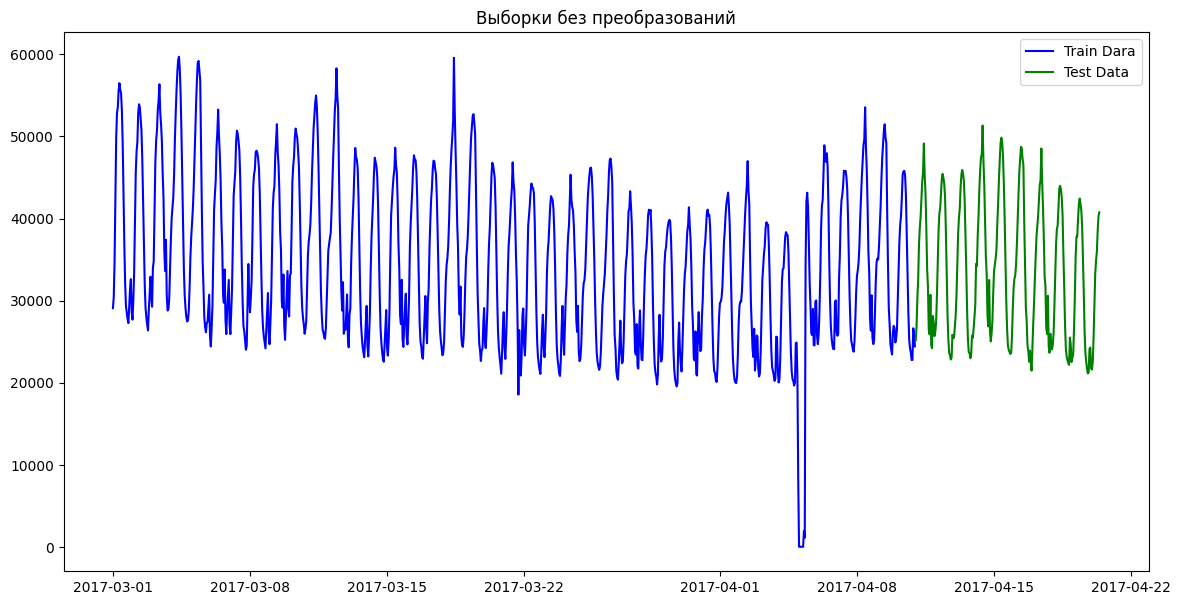

In [4]:
plt.figure(figsize=(14, 7))
plt.plot(train_f.index, train_f, label='Train Dara', color='b')
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.title('Выборки без преобразований')
plt.legend()
plt.show()

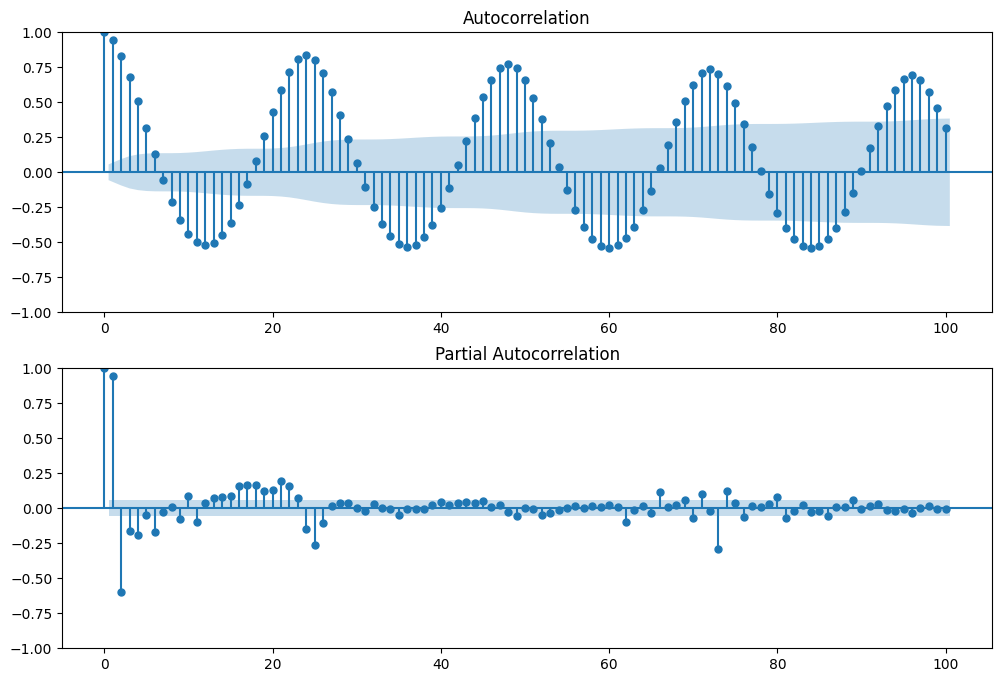

In [38]:
import statsmodels.api as sm

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(data_all, ax=ax1, lags=100)
sm.graphics.tsa.plot_pacf(data_all, ax=ax2, lags=100)
plt.show()

### Такой вид ACF может указывать на сезонность или цикличность ряда.

## Логарифмирование

In [5]:
data_all_log = np.log(data_all['Users'])

c:\Users\ksyuk\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
adf_test = adfuller(data_all_log)
print(f'p-value = {adf_test[1]}')
if adf_test[1] < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

p-value = 0.5888980070286962
Ряд не стационарен


## Обнаружение выбросов и замена их на медианное значение

In [6]:
Q1 = data_all_log.quantile(0.25)
Q3 = data_all_log.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data_all_log[(data_all_log < lower_bound) | (data_all_log > upper_bound)]
median_value = data_all_log.median()
data_all_log[outliers.index] = median_value

## Дифференцирование

In [7]:
data_all_log_diff = data_all_log.diff().dropna()
train_f_log_diff = data_all_log_diff[data_all_log_diff.index < mid_date]
test_f_log_diff = data_all_log_diff[data_all_log_diff.index >= mid_date]

train_f_log = data_all_log[data_all_log.index < mid_date]

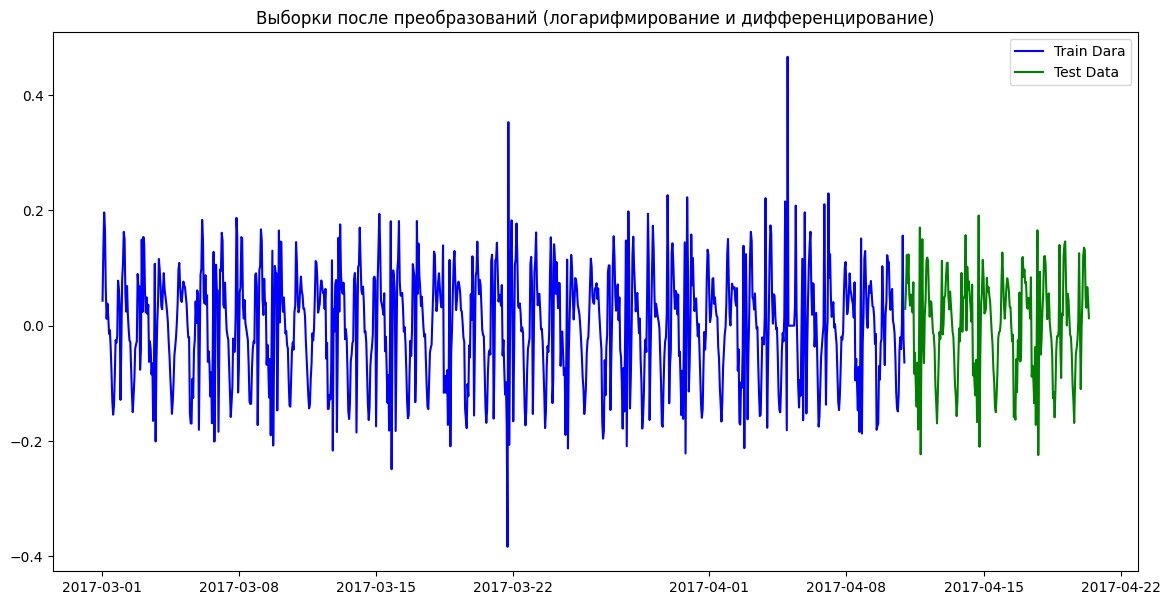

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(train_f_log_diff.index, train_f_log_diff, label='Train Dara', color='b')
plt.plot(test_f_log_diff.index, test_f_log_diff, label='Test Data', color='g')
plt.title('Выборки после преобразований (логарифмирование и дифференцирование)')
plt.legend()
plt.show()

## Проверка стационарности

In [12]:
adf_test = adfuller(data_all_log_diff)
print(f'p-value = {adf_test[1]}')
if adf_test[1] < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

p-value = 3.367163298336095e-27
Ряд стационарен


## Прогнозирование методом Хольта

In [ ]:
model_holt = ExponentialSmoothing(train_f_log_diff, damped_trend=True, trend='add', 
                                  initialization_method='estimated', seasonal='add', seasonal_periods=24).fit()

forecast_holt_diff = model_holt.forecast(steps=len(test_f_log_diff))

forecast_holt_log = train_f_log[-1] + forecast_holt_diff.cumsum()
forecast_holt = np.exp(forecast_holt_log)
test_f_log_restored = train_f_log[-1] + test_f_log_diff.cumsum()
test_f_restored = np.exp(test_f_log_restored)

## Ошибка MAE

In [54]:
mae_holt = mean_absolute_error(test_f_restored, forecast_holt)
print(f'Holt-Winters MAE: {mae_holt}')

Holt-Winters MAE: 3804.8163794228412


## Построение графика и анализ

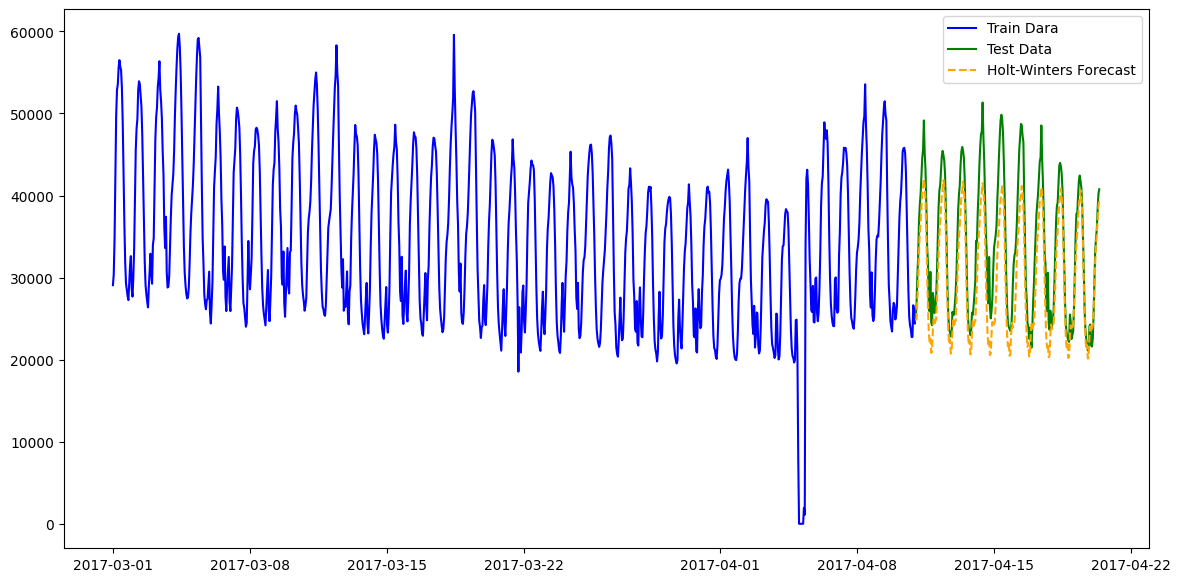

In [55]:
plt.figure(figsize=(14, 7))
plt.plot(train_f.index, train_f, label='Train Dara', color='b')
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(test_f.index, forecast_holt, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.legend()
plt.show()

## График только тестовой выборки

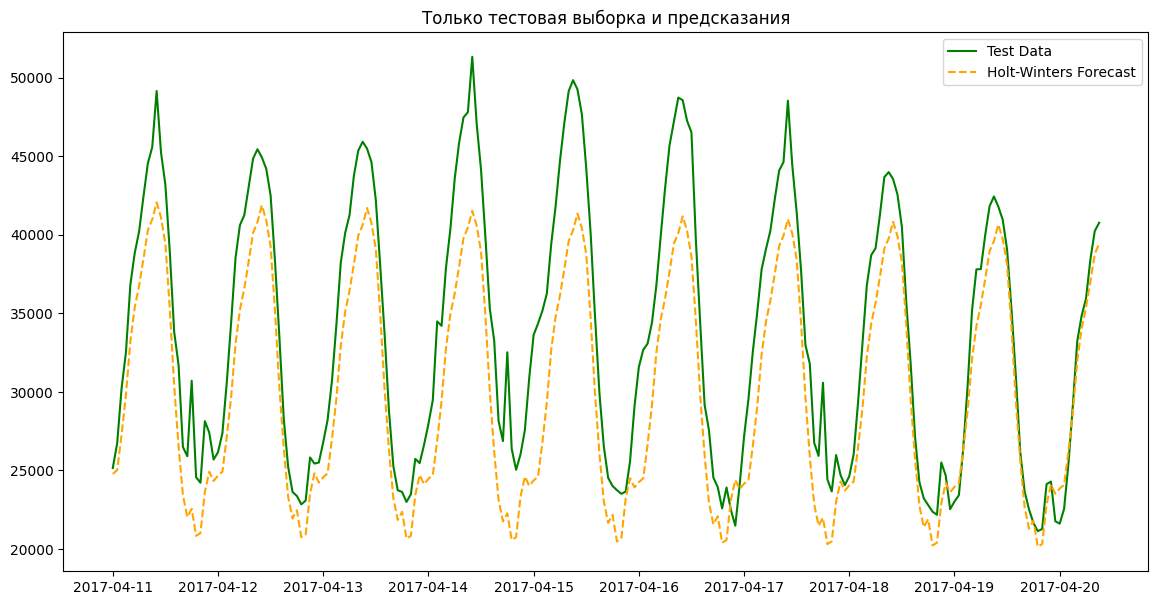

In [56]:
plt.figure(figsize=(14, 7))
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(test_f.index, forecast_holt, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.legend()
plt.title('Только тестовая выборка и предсказания')
plt.show()

## Прогнозирование на будущее

C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\ksyuk\AppData\Local\Temp\ipykernel_8652\2759201935.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

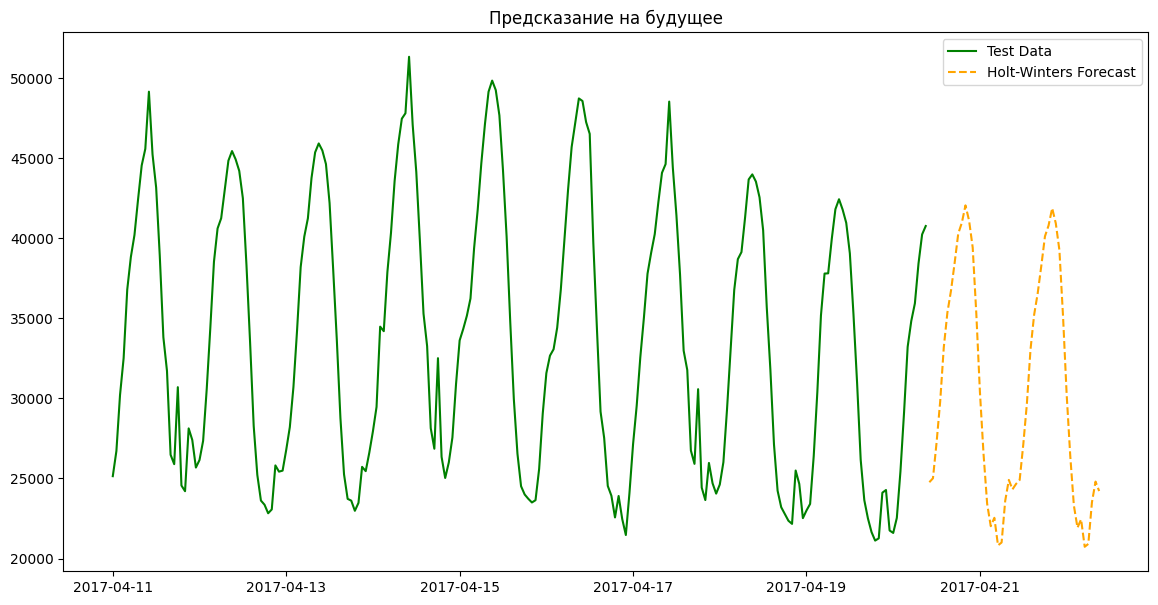

In [61]:
model_holt = ExponentialSmoothing(train_f_log_diff, damped_trend=True, trend='add', 
                                  initialization_method='estimated', seasonal='add', seasonal_periods=24).fit()
future_steps = 48  # Прогноз на 48 часов вперед (2 дня)
forecast_holt_diff_future = model_holt.forecast(steps=future_steps)

forecast_holt_log_future = train_f_log[-1] + forecast_holt_diff_future.cumsum()
forecast_holt_future = np.exp(forecast_holt_log_future)
last_date = data_all.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='H')[1:]

plt.figure(figsize=(14, 7))
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(future_dates, forecast_holt_future, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.legend()
plt.title('Предсказание на будущее')
plt.show()

## Подбор параметров с помощью Optuna

In [ ]:
import neptune
import optuna


run = neptune.init_run(
    project="delakoka/TimesSeries",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDNhNjVjYi1jZjU1LTQ5MjItODM0Zi03ZDQyNzhhZGQ2ODYifQ==",
)

def objective(trial):
    trend = trial.suggest_categorical('trend', ['add', None])
    
    if trend is not None:
        damped_trend = trial.suggest_categorical('damped_trend', [True, False])
    else:
        damped_trend = False
    
    seasonal = trial.suggest_categorical('seasonal', ['add', None])
    seasonal_periods = trial.suggest_int('seasonal_periods', 2, 48)

    # Обучение модели
    model = ExponentialSmoothing(train_f_log_diff,
                                 damped_trend=damped_trend, 
                                 trend=trend,
                                 seasonal=seasonal,
                                 seasonal_periods=seasonal_periods,
                                 initialization_method='estimated')
    
    try:
        model_fit = model.fit()
        forecast_holt_diff = model_fit.forecast(steps=len(test_f_log_diff))
        
        forecast_holt_log = train_f_log[-1] + forecast_holt_diff.cumsum()
        forecast_holt = np.exp(forecast_holt_log)
        
        mae = mean_absolute_error(test_f, forecast_holt)
        
        run['trial/mae'].log(mae)
        run['trial/params'].log(trial.params)
        
    except Exception as e:
        run['trial/exception'].log(str(e))
        mae = float('inf')
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

run['best_params'] = study.best_params
run['best_value'] = study.best_value

print(f"Best parameters: {study.best_params}")
print(f"Best MAE: {study.best_value}")

In [21]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/delakoka/TimesSeries/e/TIM-4/metadata


C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\ksyuk\AppData\Local\Temp\ipykernel_5140\3318104764.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alw

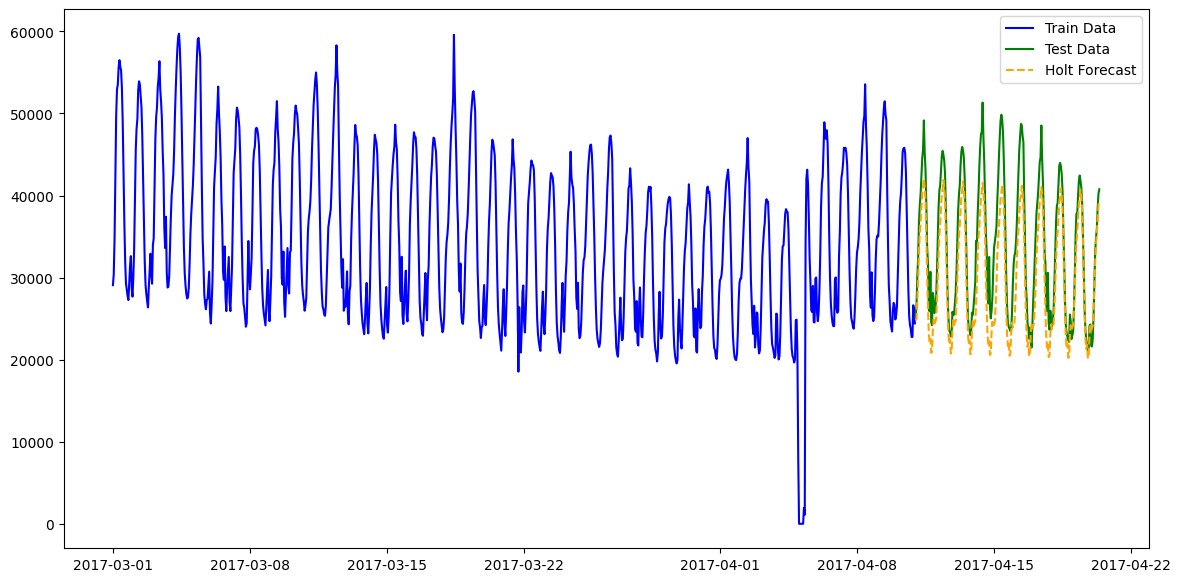

Best Holt-Winters MAE: 3788.644345519793


In [25]:
best_params = study.best_params

model_holt = ExponentialSmoothing(train_f_log_diff,
                                  trend=best_params['trend'],
                                  seasonal=best_params['seasonal'], 
                                  seasonal_periods=best_params['seasonal_periods'], 
                                  initialization_method='estimated').fit()

forecast_holt_diff = model_holt.forecast(steps=len(test_f_log_diff))

forecast_holt_log = train_f_log[-1] + forecast_holt_diff.cumsum()
forecast_holt = np.exp(forecast_holt_log)

plt.figure(figsize=(14, 7))
plt.plot(train_f.index, train_f, label='Train Data', color='b')
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(test_f.index, forecast_holt, label='Holt Forecast', color='orange', linestyle='--')
plt.legend()
plt.show()

mae_holt = mean_absolute_error(test_f, forecast_holt)
print(f'Best Holt-Winters MAE: {mae_holt}')

C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\ksyuk\AppData\Local\Temp\ipykernel_5140\3534885977.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_holt_log_future = train_f_log[-1] + forecast_holt_diff_future.cumsum()
C:\Users\ksyuk\AppData\Local\Temp\ipykernel_5140\3534885977.py:10: FutureWarn

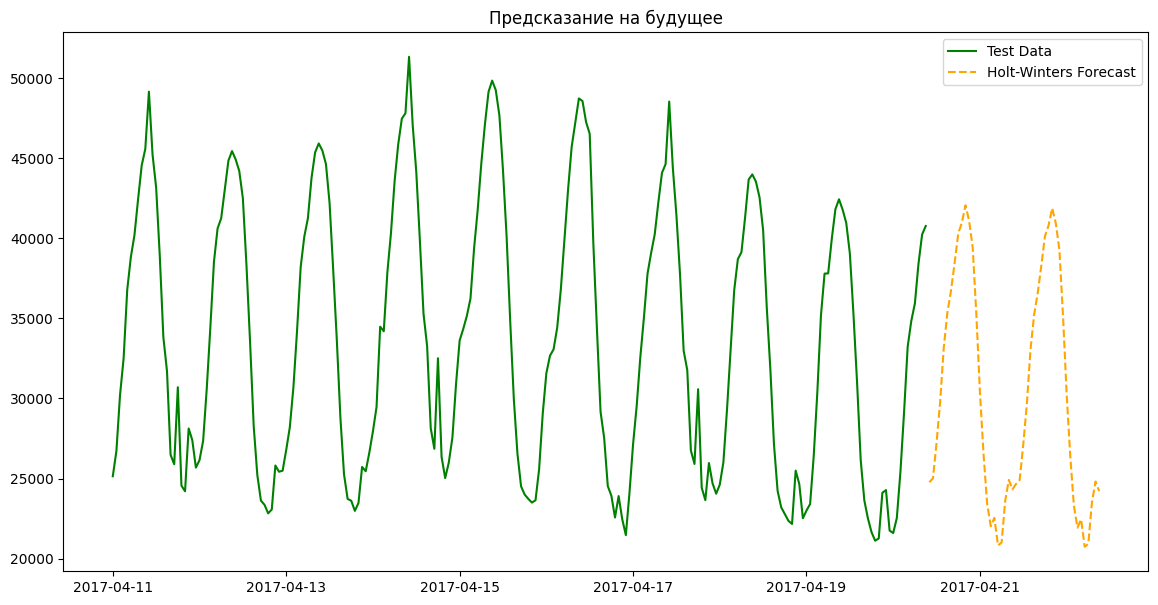

In [36]:
model_holt = ExponentialSmoothing(train_f_log_diff,
                                 trend = None, seasonal= 'add', seasonal_periods= 24, 
                                  initialization_method='estimated').fit()
future_steps = 48  # Прогноз на 48 часов вперед (2 дня)
forecast_holt_diff_future = model_holt.forecast(steps=future_steps)

forecast_holt_log_future = train_f_log[-1] + forecast_holt_diff_future.cumsum()
forecast_holt_future = np.exp(forecast_holt_log_future)
last_date = data_all.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='H')[1:]

plt.figure(figsize=(14, 7))
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(future_dates, forecast_holt_future, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.legend()
plt.title('Предсказание на будущее')
plt.show()

## ARIMA c Optune

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


def objective(trial):
    p = trial.suggest_int('p', 0, 20)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 20)
    
    # Создание и обучение модели ARIMA
    model = ARIMA(train_f_log_diff, order=(p, d, q))
    try:
        model_fit = model.fit()
    except ValueError as e:
        return float("inf")  # Возвращаем бесконечное значение при ошибке

    # Прогнозирование
    forecast_arima_diff = model_fit.get_forecast(steps=len(test_f_log_diff)).predicted_mean
    
    # Восстановление исходного уровня ряда
    forecast_arima_log = train_f_log[-1] + forecast_arima_diff.cumsum()
    forecast_arima = np.exp(forecast_arima_log)
    
    # Оценка модели
    mae = mean_absolute_error(test_f, forecast_arima)
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best Parameters:", best_params)

C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starti

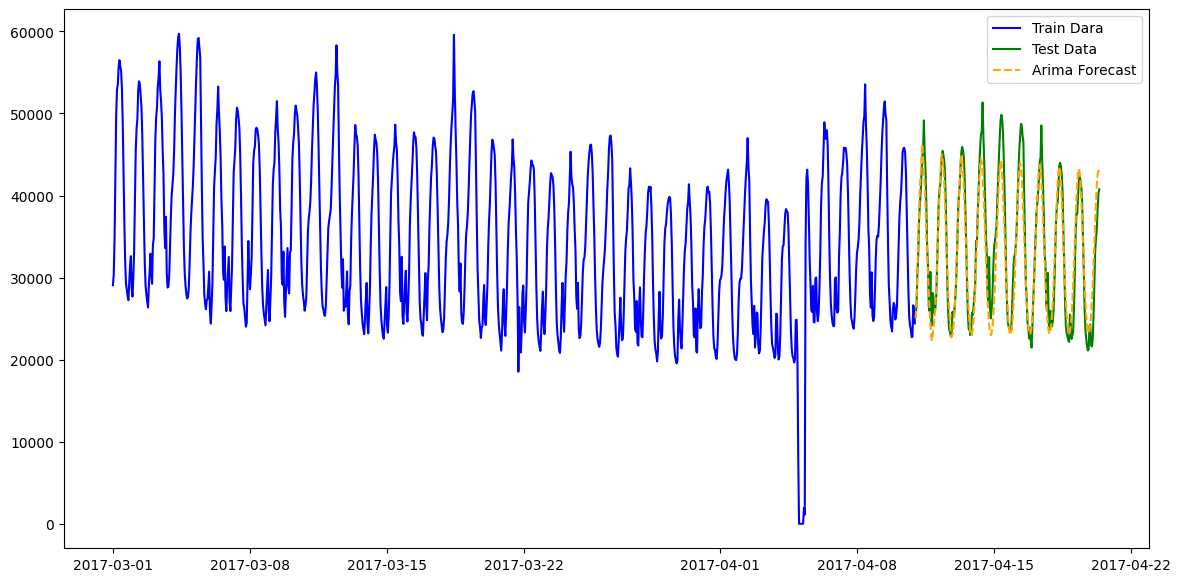

In [32]:
model = ARIMA(train_f_log_diff, order=(16,0,13))
model_fit = model.fit()

forecast_arima_diff = model_fit.get_forecast(steps=len(test_f_log_diff)).predicted_mean

forecast_arima_log = train_f_log[-1] + forecast_arima_diff.cumsum()
forecast_arima = np.exp(forecast_arima_log)
test_f_log_restored = train_f_log[-1] + test_f_log_diff.cumsum()
test_f_restored = np.exp(test_f_log_restored)

# Визуализация
plt.figure(figsize=(14, 7))
plt.plot(train_f.index, train_f, label='Train Dara', color='b')
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(test_f.index, forecast_arima, label='Arima Forecast', color='orange', linestyle='--')
plt.legend()
plt.show()

In [33]:
mae_arima = mean_absolute_error(test_f_restored, forecast_arima)
print(f'ARIMA MAE: {mae_arima}')

ARIMA MAE: 2283.0874192670913


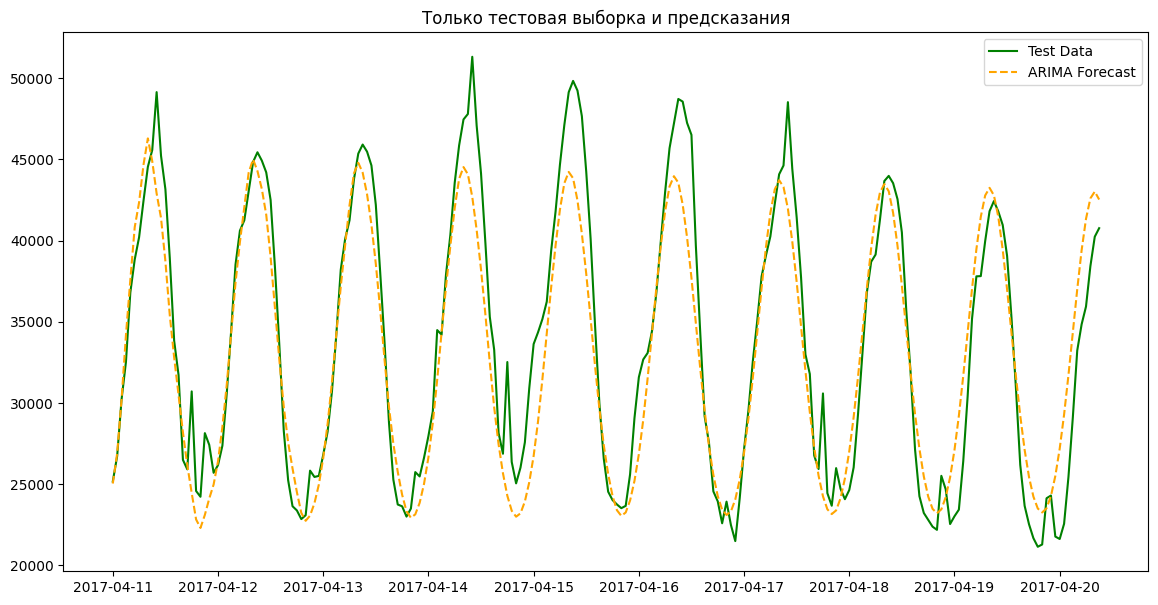

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(test_f.index, forecast_arima, label='ARIMA Forecast', color='orange', linestyle='--')
plt.legend()
plt.title('Только тестовая выборка и предсказания')
plt.show()

C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starti

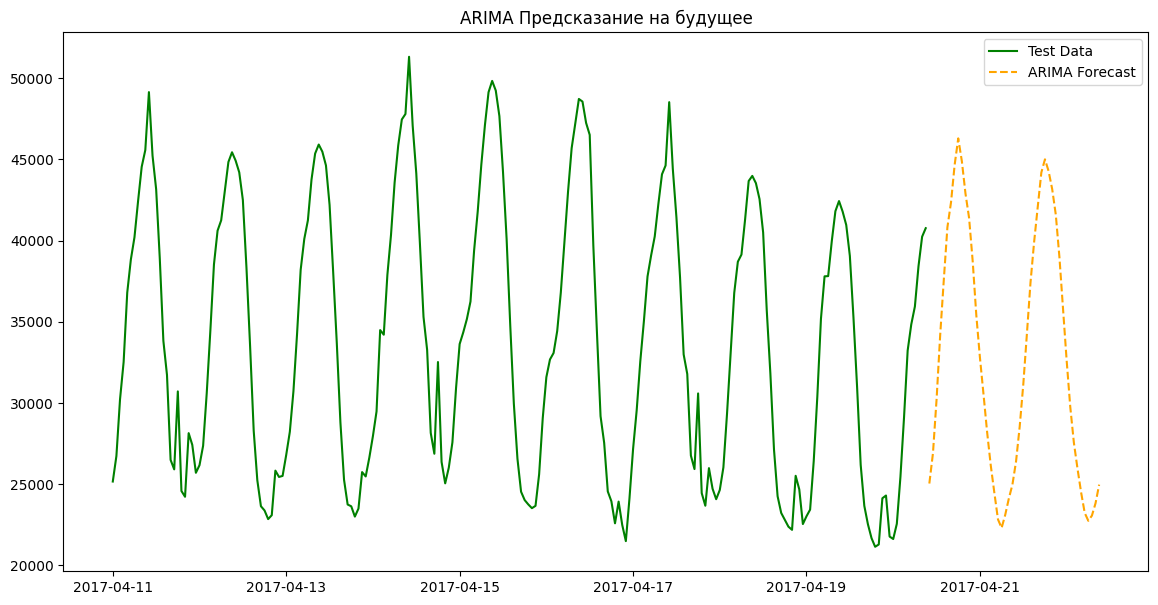

In [37]:
full_model = ARIMA(train_f_log_diff, 
                   order=(16, 0, 13))
full_model_fit = full_model.fit()

future_steps = 48  # Прогноз на 48 часов вперед (2 дня)
forecast_arima_diff_future = full_model_fit.get_forecast(steps=future_steps).predicted_mean

forecast_arima_log_future = train_f_log[-1] + forecast_arima_diff_future.cumsum()
forecast_arima_future = np.exp(forecast_arima_log_future)
last_date = data_all.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='H')[1:]

plt.figure(figsize=(14, 7))
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(future_dates, forecast_arima_future, label='ARIMA Forecast', color='orange', linestyle='--')
plt.legend()
plt.title('ARIMA Предсказание на будущее')
plt.show()

## Таким образом, с преобразованными данными (сначала логарифмирование, убирание выбросов, а потом дифференцирование) лучше всего справилась модель ARIMA. Она получила наименьшую ошибку 2283.

# <strong>Основные понятия:</strong>

### <strong>Шаг временного ряда</strong> — это признак, которые можно напрямую вывести из временной метки (секунды, минуты, часы, дни, недели и т.д.).
### <strong>Тренд (Trend)</strong>: показывает общее направление движения данных временного ряда на протяжении длительного времени. Это может быть восходящий тренд (увеличение значений), нисходящий тренд (уменьшение значений) или отсутствие тренда (значения остаются примерно на одном уровне).
### <strong>Сезонность (Seasonality)</strong>: повторяющиеся колебания данных временного ряда, которые происходят с регулярными интервалами времени, например, ежемесячно, ежеквартально или ежегодно.
### <strong>Цикличность (Cyclical)</strong>:  колебания временного ряда, которые происходят на более длительных временных интервалах и не обязательно регулярны. Циклы могут быть связаны с экономическими, политическими или другими внешними факторами.
### <strong>Нерегулярность/остатки (Irregularity/residuals)</strong>: представляют собой случайные и непредсказуемые изменения в данных временного ряда, которые не связаны с трендом, сезонностью или цикличностью. 
### <strong>Стационарные временные ряды должны соответствовать следующим правилам</strong>: 
<li>Среднее значение уровней ряда не изменяется во времени, т. е. математическое ожидание постоянно.
<li>Автоковариация (т. е. ковариация между уровнями одного и того же ряда) зависит только от того, насколько сильно они удалены друг от друга во времени, и не зависит от того, находятся ли они в начале или в конце временного ряда. 
<li>Дисперсия стационарного временного ряда также не меняется со временем.

### <strong>Детерминирование тренда</strong> - этот метод заключается в удалении эффекта тренда из исходного набора данных и отображении только отклонений значений от тренда. Он позволяет выявить циклические паттерны в данных. 
<li> Вычисление скользящего среднего - среднего значения в определенном окне данных. Скользящее среднее позволяет сгладить тренд и выделить его основные тенденции.
<li> Метод линейной регрессии. Заключается в аппроксимации тренда с помощью линейной функции. Коэффициенты линейной функции можно найти с помощью метода наименьших квадратов.
<li> Метод экспоненциального сглаживания. Основан на идее, что более новые значения данных более информативны, чем старые. Экспоненциальное сглаживание использует весовую функцию, которая экспоненциально убывает с течением времени.
<li> Метод Холта-Винтера. Является расширением метода экспоненциального сглаживания, которое учитывает сезонность данных.

### <strong>Дифференцирование</strong> - это простое преобразование ряда в новый временной ряд. Оно используется для устранения зависимости ряда от времени и стабилизации среднего значения ряда. В процессе дифференцирования тренд и сезонность уменьшаются.
### <strong>Трансформация данных</strong>:
<li> Степенное преобразование: применяется для данных, сильно отклоняющихся от нуля;
<li> Взятие квадратного корня: используется для данных, имеющих значения, сгруппированные вокруг нуля;
<li> Логарифмирование: подходит для данных, резко возрастающих или колеблющихся вокруг положительных значений.

### <strong>Модели ARMA и  ARIMA определяются тремя параметрами</strong>:
<li> p (autoregressive lags): Количество прошлых значений временного ряда, которые используются для прогнозирования текущего значения.
<li> q (moving average lags): Количество ошибок прогноза прошлых периодов, которые учитываются при формировании нового прогноза.
<li> d (difference in the order): Число раз, которое необходимо продифференцировать данные, чтобы сделать их стационарными (т.е. устранить тренд и сезонность). В модели ARMA порядок разностей обычно равен нулю, поскольку ARMA не требует дифференцирования данных.

### <strong>Параметры AR (p)</strong>: На PACF-графике значимые пики на первых нескольких лагах (например, 1 и 5), что может указывать на AR-компоненты. Параметр p может быть около 5 или 10.
### <strong>Параметры MA (q)</strong>: На ACF-графике видны значительные пики на нескольких лагах, что указывает на наличие MA-компоненты. Параметр q может быть около 5 или 10.
### <strong>Сезонность</strong>: Значительные пики на ACF и PACF на интервалах около 5 лагов указывают на сезонность в данных. Это можно учитывать в модели ARIMA, добавив сезонные параметры.